In [10]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import image_utils
from PIL import Image
import pickle
import json
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

In [2]:
root_path = "/mnt/brics_data/datasets/Rio/fiocruz/raw"

In [3]:
df = pd.read_csv(root_path+"/Rio_fiocruz_table_from_raw.csv")
def add_path(row):
    return root_path+'/'+row.image_path
df['image_path']=df.apply(lambda row: add_path(row),axis='columns')
df=df.sample(1)

In [4]:
df.head()

,Unnamed: 0,dataset_name,project_id,image_path,target,metadata,insertion_date
415,415,fiocruz,MS_025_02.04,/mnt/brics_data/datasets/Rio/fiocruz/raw/image...,0,{},NaN


In [5]:
image_path = df.image_path.values[0]

In [14]:
def preproc_image( path ,channels=3, image_shape=(256,256), crop : bool=False):
    image_encoded = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image_encoded, channels=channels)
    image = tf.cast(image, dtype=tf.float32) / tf.constant(255., dtype=tf.float32)
    if crop:
        shape = tf.shape(image) 
        image = tf.image.crop_to_bounding_box(image, 0,0,shape[0]-70,shape[1])
    image = tf.image.resize(image, image_shape, method='nearest')
    return image.numpy()

def load_model( path ):
    with open(path, 'rb') as f:
        d = pickle.load(f)
        metadata = d['metadata']
        model = d["model"]
        model = tf.keras.models.model_from_json( json.dumps( d['model']['sequence'], separators=(',',':')) )
        model.set_weights( d['model']['weights'] ) 
        history = d['history']
        return model, history

model_path="/mnt/brics_data/models/v1/user.philipp.gaspar.convnets_v1.baseline.shenzhen_santacasa.exp.20240207.r1/job.test_0.sort_0/output.pkl"
model , history = load_model(model_path)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 64)        0

In [32]:
image_proc = preproc_image(image_path, crop=True)
image_proc.shape

(256, 256, 3)

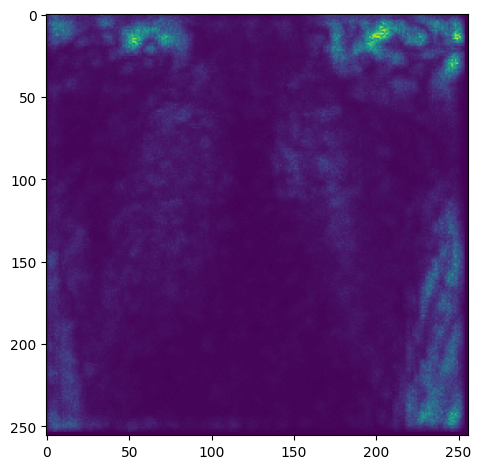

In [90]:
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize
from vis.utils import utils

def get_saliency( model, image ):
  img=image
  if len(img.shape) == 3:
    img = img[np.newaxis]
  layer_idx = utils.find_layer_idx(model, model.layers[-1].name)
  model.layers[-1].activation = tf.keras.activations.linear
  model = utils.apply_modifications(model)
  score = CategoricalScore([0])
  saliency = Saliency(model, clone=False)
  saliency_map = saliency(score, image, smooth_samples=10, smooth_noise=0.2)
  saliency_map = normalize(saliency_map)
  return saliency_map



#cam=generate_saliency_map(model, image_proc, 0, 0)


saliency_map=get_saliency(model, image_proc)
f, ax = plt.subplots(1,1)
ax.imshow(saliency_map[0])
plt.tight_layout()
plt.show()

In [72]:
saliency_map[0][0][0]

0.05184278